In [1]:
# Thanks to Max Silva for contributing to this!

In [3]:
from utils import *

### Let's load the observation

In [2]:
# Load the obsdB from context
logger = logging.getLogger(__name__)
context = Context('/mnt/so1/shared/todsims/pipe-s0002/v4/context/context.yaml')
obs = context.obsdb.get()

In [5]:
#ONGOING: the context.yaml is compatible with pipe-s0002/v4. 
# Currently upgrading to v6, where info is contained in hdf5.

The context file specifies how to load the data and it calls preprocess_configs.yaml in which: 
- ${\tt AxisManager \ (aman)}$ - The data object is in this format, similar to np.array but specifying the axes, which makes it easier to cut the data along a specific axis. For example, one element can be the TOD signal, with axes (or dimensions) $N_{dets}$ and $N_{samp}$; another can be the timestamps, with axis $N_{samp}$. If you want to get rid of a given timestamp, the equivalent sample will also be deleted in the TOD signal when you apply the filter along the axis $N_{samp}$. 
- ${\tt process\_pipe}$ - specifies the different operations and filters applied to the data in the form of:
   - ${\tt calc}$ - makes an array that is merged into the aman file by creating a new axis
   - ${\tt process}$ - uses selected modes to subtract modes from the data 

In [3]:
# Inspect what is in the obsdB
for ob in obs:
    print(ob)

OrderedDict([('obs_id', 'CES-Atacama-SAT1-Tier1DEC-035..-045_RA+040..+050-0-0_MFF'), ('timestamp', 1626334193.054054), ('tube_set', 'MFF'), ('duration', 853.8918919563293), ('drift', 'rising'), ('az_min', -242.79171524232558), ('az_max', -229.97828488508077), ('az_med', -236.45384856986252), ('el_min', 34.04003048070242), ('el_max', 37.0399695225171), ('el_med', 35.53999999999999), ('is_const_el', 0), ('is_const_az', 0), ('is_stare', 0)])
OrderedDict([('obs_id', 'CES-Atacama-SAT1-Tier1DEC-035..-045_RA+040..+050-0-1_MFF'), ('timestamp', 1626335033.054054), ('tube_set', 'MFF'), ('duration', 853.8918919563293), ('drift', 'rising'), ('az_min', -242.7817145425811), ('az_max', -229.9782847512306), ('az_med', -236.45361190154796), ('el_min', 34.040030480702406), ('el_max', 37.039969522517126), ('el_med', 35.53999999999999), ('is_const_el', 0), ('is_const_az', 0), ('is_stare', 0)])
OrderedDict([('obs_id', 'CES-Atacama-SAT1-Tier1DEC-035..-045_RA+040..+050-0-2_MFF'), ('timestamp', 1626335873.054

Here, for each observation we have: the site (Atacama), the telescope (SAT1), the observed patch spanning given ra-dec coordinates, the timestamp in Unix computing time (ctime), info about the azimuth, the elevation.

In [4]:
# Select an observation to load
obs_idx = 0 #first observation 
this_obs = obs[obs_idx]
obs_id = this_obs['obs_id']

In [5]:
groups = context.obsfiledb.get_detsets(obs_id)
for group in groups:
    print(group)

MFF1_wafer_19
MFF1_wafer_20
MFF1_wafer_21
MFF1_wafer_22
MFF1_wafer_23
MFF1_wafer_24
MFF1_wafer_25
MFF2_wafer_19
MFF2_wafer_20
MFF2_wafer_21
MFF2_wafer_22
MFF2_wafer_23
MFF2_wafer_24
MFF2_wafer_25


The groups specify what the frequency of the observations (MF = middle frequency, F1 = frequency 1), and the wafer number. Here we have the 2 SO-SAT middle frequencies (90 and 150 GHz) and 7 waifers.

In [6]:
# Create a mask to select 2 groups corresponding to 1 wafer, 2 freqs
m = np.asarray([1,0,0,0,0,0,0,1,0,0,0,0,0,0]).astype(bool)
list(np.asarray(groups)[m])

['MFF1_wafer_19', 'MFF2_wafer_19']

In [7]:
# Select wafer 19 x 90 GHz to process
group = groups[0]

In [8]:
# Load data
aman = context.get_obs(obs_id,detsets=group)

In [9]:
aman

AxisManager(signal[dets,samps], timestamps[samps], boresight*[samps], qboresight_azel[samps,4], qboresight_radec[samps,4], site*[samps], hwp_angle[samps], flags*[dets,samps], obs_info*, focal_plane*[dets], det_info*[dets], dets:LabelAxis(860), samps:OffsetAxis(31596))

Each item in the aman is an array with axes $[N_1, N_2]$. When an item has a $^*$ it means that it's itself another aman object, e.g.:

In [10]:
aman.boresight

AxisManager(az[samps], el[samps], roll[samps], samps:OffsetAxis(31596))

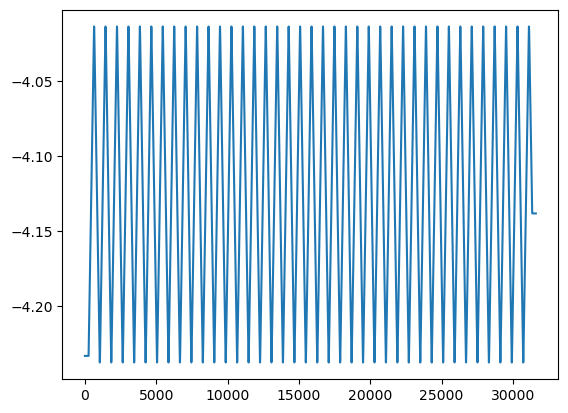

In [11]:
# Let's plot the boresight azimuth: we expect it to go up and down in
# as the specified region inside the North/South SAT patch is scanned
plt.plot(aman.boresight.az)

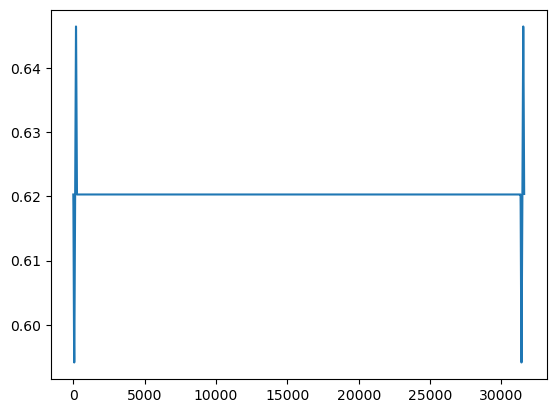

In [12]:
# Let's plot the boresight elevation: we expect it to be approximately 
# constant, except at the edges where it goes up and down to calibrate 
# depending on the temperature perceived at different altitudes.
plt.plot(aman.boresight.el)

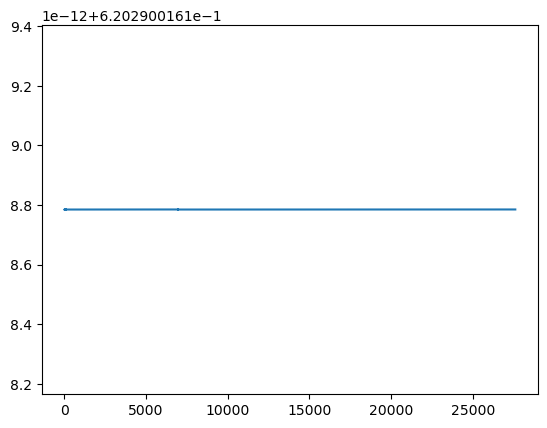

In [13]:
# Let's get rid of the edges
si, ei = 2000, -2000
plt.plot(aman.boresight.el[si:ei])

In [14]:
# Apply this restriction to all the objects 
# along the axis samps
aman.restrict('samps', (si,ei))

AxisManager(signal[dets,samps], timestamps[samps], boresight*[samps], qboresight_azel[samps,4], qboresight_radec[samps,4], site*[samps], hwp_angle[samps], flags*[dets,samps], obs_info*, focal_plane*[dets], det_info*[dets], dets:LabelAxis(860), samps:OffsetAxis(27596))

Note that ${\tt samps}$ has gone from 31596 to (31596-4000=27596)!

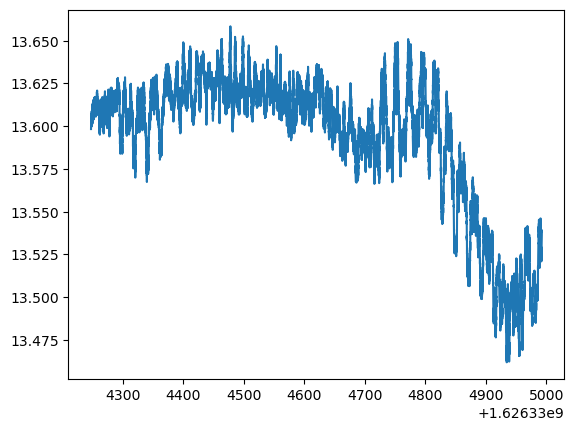

In [15]:
# Let's plot the TOD
plt.plot(aman.timestamps, aman.signal[0])

The TOD looks quite "chunky". This is mainly due to the presence of the atmosphere.

This is more visible in the PSD (below), where the bump at larger scales reflects the 1/f noise of the atmosphere.

In [16]:
from sotodlib.tod_ops.fft_ops import calc_psd

In [17]:
# Let's calculate the PSD
freqs, Pxx = calc_psd(aman)

If we merge, i.e. ${\tt calc\_psd(aman,merge=True)}$, this creates 2 additional objects in the aman file: one for the frequencies (${\tt freqs}$), and one for the 1D fourier transform or PSD (${\tt Pxx}$).

In [18]:
#aman

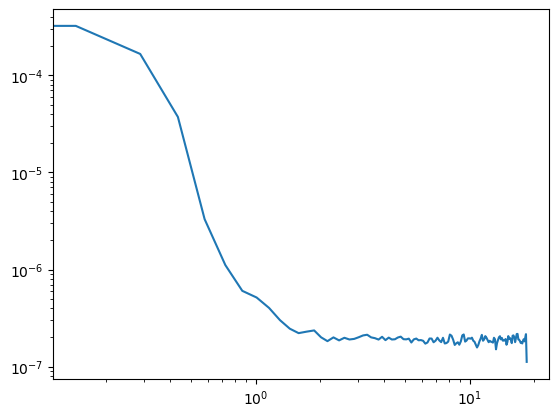

In [19]:
plt.loglog(freqs,Pxx[0])

By inspecting the PSD, we don't see any peaks around the frequency of the HWP, which suggests that no HWP modulation was included in the simulation. We also don't see any HWP synchronous signal, which would appear as a series of repetitive peaks at different frequencies, which implies no HWPSS was included in the sim. We also don't see any evident glitches in the TOD. Therefore, we can create a config file for the filters, without including any HWP demodulation, nor operations/filters to correct for the aformentioned effects. 

### Apply the "filters"

In [20]:
# Let's load the config file created 
configs="./pipe_s0002_sim_preprocess.yaml"
configs = yaml.safe_load(open(configs, "r"))

In [21]:
# And build the pipeline including the filters 
# specified in the config
pipe = _build_pipe_from_configs(configs)
proc_aman = core.AxisManager( aman.dets, aman.samps)

Let's apply each filter specified in the config, and plot the effects on the data.

In [22]:
# 1) Detrended
pi = 0
process = pipe[pi]
print(f"Processing {process.name}")
process.process(aman, proc_aman)
process.calc_and_save(aman, proc_aman)

Processing detrend


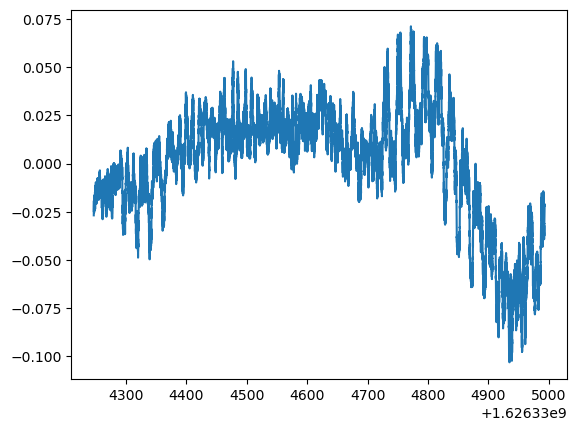

In [23]:
plt.plot(aman.timestamps, aman.signal[0])

Detrending means that one straight line is fit between the beginning and the end of the TOD (it will be an oblique line), and this line is subtracted from the data, such that initial and final point of the TOD will have the same y-value.

In [24]:
# 2) Apodize
pi = 1
process = pipe[pi]
print(f"Processing {process.name}")
process.process(aman, proc_aman)
process.calc_and_save(aman, proc_aman)

Processing apodize


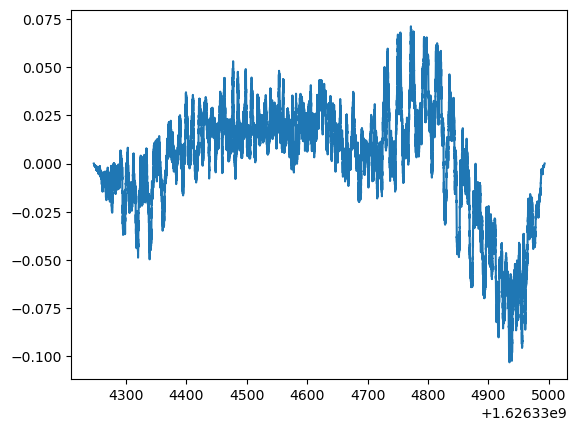

In [25]:
plt.plot(aman.timestamps, aman.signal[0])

This is similar to the kind of apodization process that you would apply to the maps at the edges of the mask. In practice, you are applying a cosine filter at the edges of the TOD (the edges are in fact different from the previous plot). 

### Demodulate and make maps

In [26]:
# 3) Demodulate
pi = 2
process = pipe[pi]
print(f"Processing {process.name}")
process.process(aman, proc_aman)
process.calc_and_save(aman, proc_aman)

Processing demodulate


Demodulating means you shift the peak where the polarization signal is in frequency (on the right/away from the 1/f bump of the atmosphere) back to the centre of the frequency axis and you filter cut away everything that is on smaller scales compared to that.

In [27]:
# Let's print the definition of this function
#process.calc_and_save??

It returns dsT, demodQ, demodU. dsT is the non-demodulated T signal, while the rest is the demodulated Q/U polarization signal, where the atmosphere is taken care of. The latter should therefore look like white noise. 

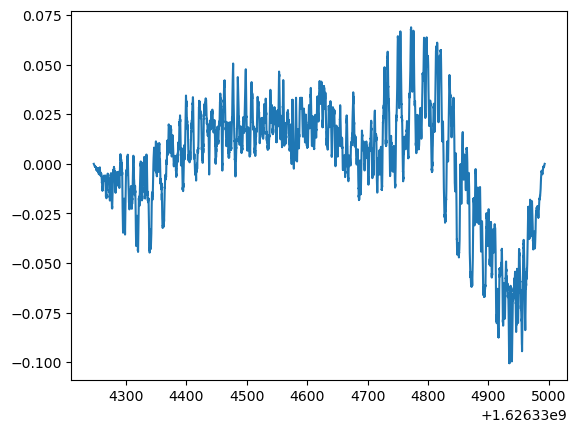

In [28]:
plt.plot(aman.timestamps, aman.dsT[0])

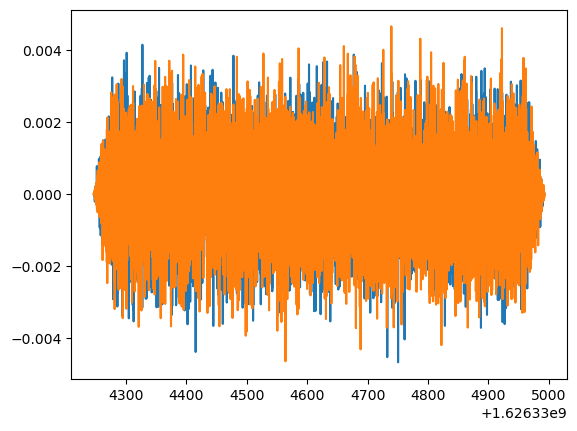

In [29]:
plt.plot(aman.timestamps, aman.demodQ[0])
plt.plot(aman.timestamps, aman.demodU[0])

In [30]:
freqs, Pxx_T = calc_psd(aman=aman, signal=aman.dsT)
_, Pxx_Q = calc_psd(aman=aman, signal=aman.demodQ)
_, Pxx_U = calc_psd(aman=aman, signal=aman.demodU)

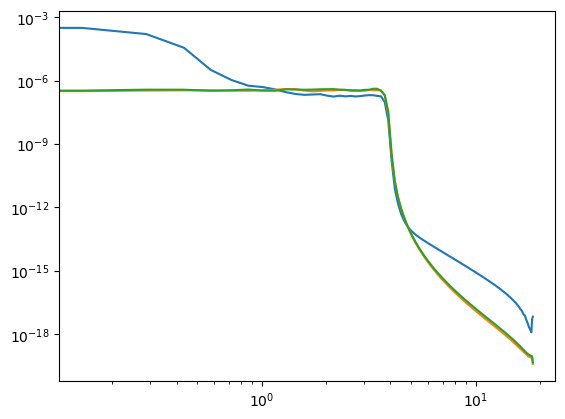

In [31]:
plt.loglog(freqs,Pxx_T[0])
plt.loglog(freqs,Pxx_Q[0])
plt.loglog(freqs,Pxx_U[0])

It does indeed look like white noise for the demodulated Q and U below freq < 4 Hz!

In [32]:
#demod.make_map?

#### Mapmaker (implemented in sotodlib)

In [33]:
# Make map
from sotodlib.coords import demod
from sotodlib import coords
res = .02*coords.DEG # select resolution 
map_dict = demod.make_map(aman, res=res, dsT=aman.dsT, demodQ=aman.demodQ, demodU=aman.demodU)

In [34]:
map_dict.keys()

dict_keys(['map', 'weighted_map', 'weight'])

- "Unweighted" map, i.e. map of temperature and polarization;
- Weighted map, i.e. the inverse variance weighted map of temperature and polarization;
- Weights applied, i.e. the map of inverse variance weights used in the map-making process.

In [35]:
from pixell import enmap, enplot
from pixell import enplot
def eshow(x,**kwargs): enplot.show(enplot.plot(x,**kwargs))

Text(0.5, 1.0, 'Total U')

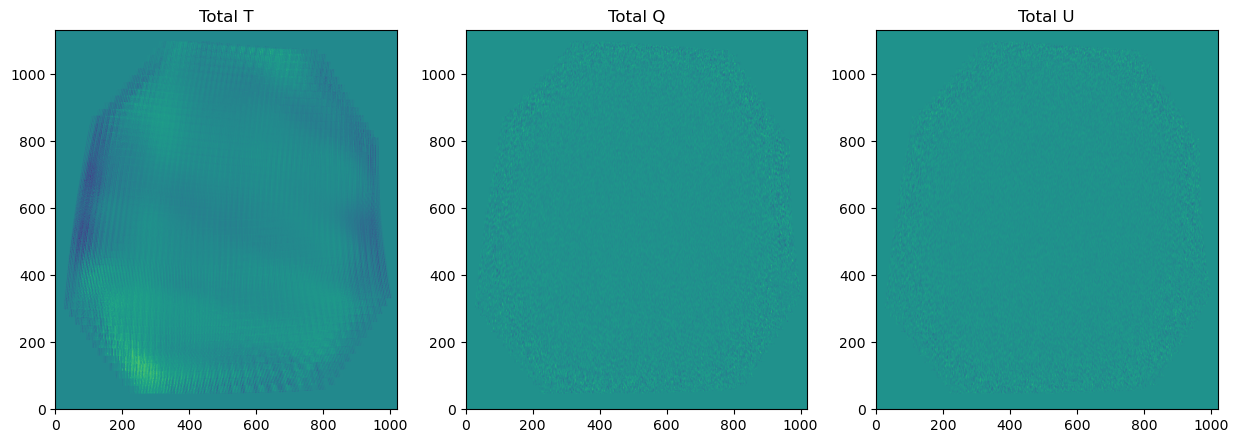

In [37]:
fig, axes = plt.subplots(1,3,figsize = (15,5))
ax = axes.flatten()
for _i,_m in enumerate(map_dict['map']):
    ax[_i].imshow(_m, origin='lower')
ax[0].set_title('Total T')
ax[1].set_title('Total Q')
ax[2].set_title('Total U')

These maps include the filters and can be used into BBMaster.

Text(0.5, 1.0, 'Weighted U')

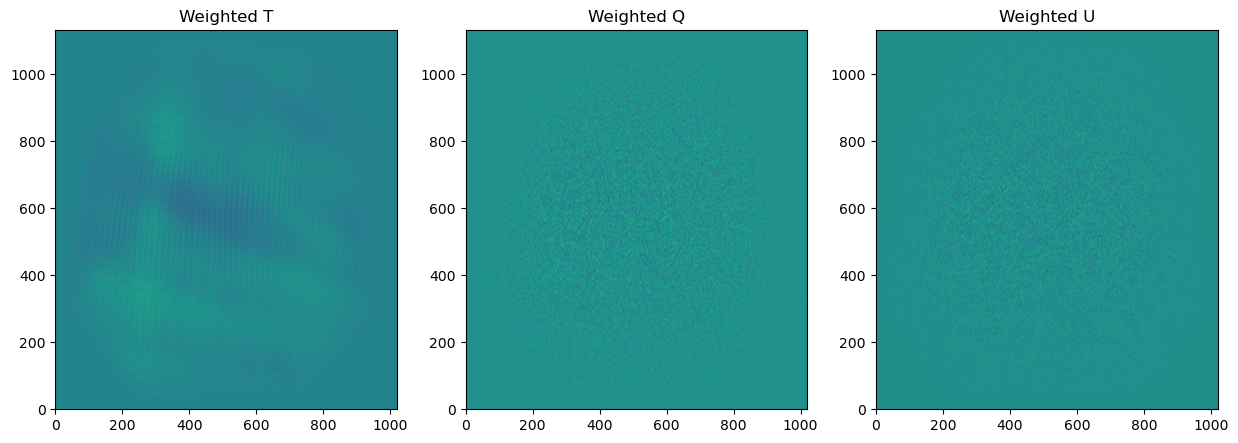

In [38]:
fig, axes = plt.subplots(1,3,figsize = (15,5))
ax = axes.flatten()
for _i,_m in enumerate(map_dict['weighted_map']):
    ax[_i].imshow(_m, origin='lower')
ax[0].set_title('Weighted T')
ax[1].set_title('Weighted Q')
ax[2].set_title('Weighted U')

In [39]:
map_dict['weight'].shape

(3, 3, 1133, 1021)

In [40]:
map_dict['weighted_map'].shape

(3, 1133, 1021)

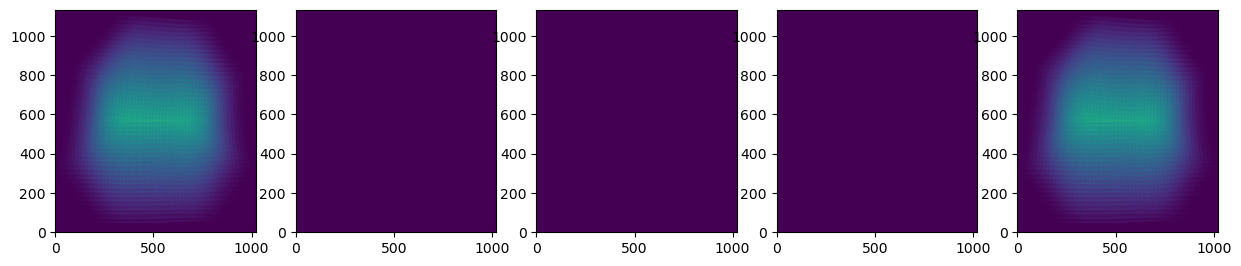

In [41]:
fig, axes = plt.subplots(1,5,figsize = (15,5))
ax = axes.flatten()
for _i,_m in enumerate(map_dict['weight']):
    for _j,_n in enumerate(map_dict['weight']):
        ax[_i+_j].imshow(map_dict['weight'][_i,_j,:,:], origin='lower')

#### Mapmaker and demodulation breakdown
check:
[demod.py](https://github.com/simonsobs/sotodlib/blob/beff6c098a18331c0d945d198366a3cde91d18e9/sotodlib/coords/demod.py#L8)
[hwp.py](https://github.com/simonsobs/sotodlib/blob/beff6c098a18331c0d945d198366a3cde91d18e9/sotodlib/hwp/hwp.py#L582)

Check if equivalent to before?

### Plot detectors

In [42]:
# Most angles are in radians, so here's a convenience unit.
DEG = np.pi/180

Text(0, 0.5, 'DEC (deg)')

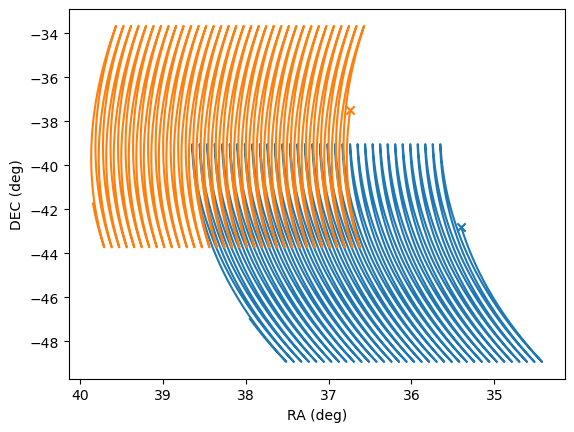

In [43]:
# Plot the (ra, dec) of some detectors.
radec = coords.get_radec(tod=aman)
plt.figure()
dets = [10, 200]
for det_idx in dets:
    ra, dec = radec[det_idx,:,:2].transpose()
    plt.plot(ra/DEG, dec/DEG)
    plt.scatter([ra[0]/DEG], [dec[0]/DEG], marker='x')
plt.gca().invert_xaxis()
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')

### Reproject into healpix

In [44]:
import pixell
pixell.__version__

'0.20.1'

In [57]:
import healpy as hp
import warnings
warnings.simplefilter("ignore")
from pixell import enmap, enplot, utils, coordinates #reproject #wcsutils

In [54]:
m_hp = map_dict['map'][0,:,:].to_healpix(nside=512, order=0)
w_hp = map_dict['weight'][0,0,:,:].to_healpix(nside=512, order=0)
mt_hp = map_dict['weighted_map'][0,:,:].to_healpix(nside=512, order=0)

<Figure size 3000x3000 with 0 Axes>

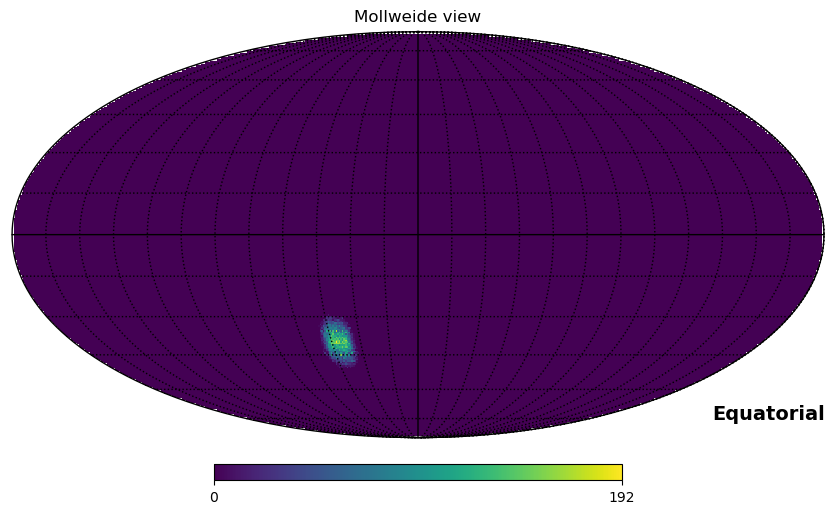

In [59]:
plt.figure(figsize=(30,30))
hp.mollview(w_hp, xsize=512, coord='C')
hp.graticule(15, verbose=False)
#plt.savefig('./hp.png')

<Figure size 3000x3000 with 0 Axes>

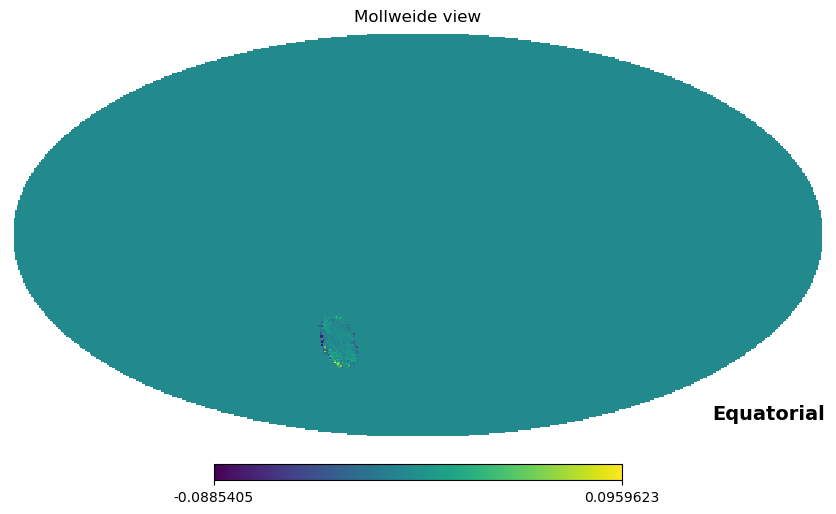

In [63]:
plt.figure(figsize=(30,30))
hp.mollview(m_hp, xsize=512, coord='C')
#hp.graticule(15, verbose=False)

<Figure size 3000x3000 with 0 Axes>

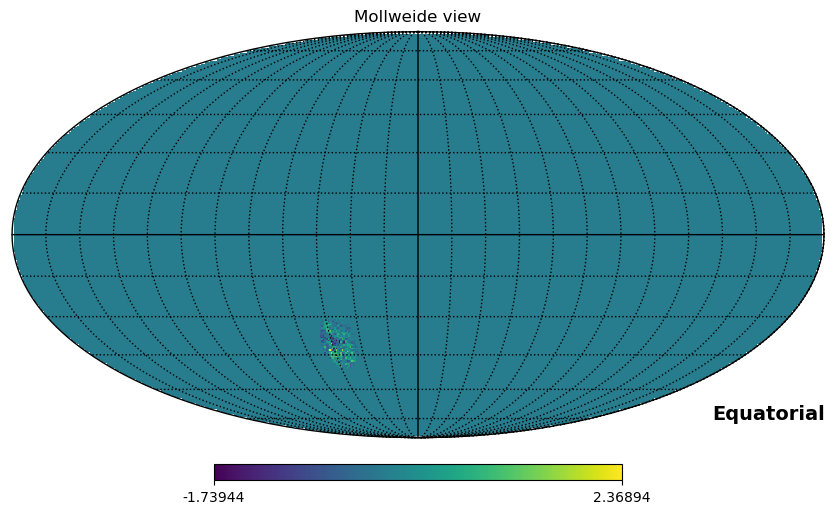

In [64]:
plt.figure(figsize=(30,30))
hp.mollview(mt_hp, xsize=512, coord='C')
hp.graticule(15, verbose=False)
#plt.savefig('./hp.png')